In [1]:
%run ./check_DOVS_METHODS.ipynb

In [2]:
from importlib import reload
#reload(Utilities)
#reload(clm)

import sys, os
import re

import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype, is_datetime64_dtype, is_timedelta64_dtype
from scipy import stats
import datetime
import time
from natsort import natsorted, ns
from packaging import version

import copy

import itertools

import pyodbc
#---------------------------------------------------------------------
sys.path.insert(0, os.path.realpath('..'))
import Utilities_config
#-----
import CommonLearningMethods as clm
#-----
from MeterPremise import MeterPremise
#-----
from AMI_SQL import AMI_SQL
from AMINonVee_SQL import AMINonVee_SQL
from AMIEndEvents_SQL import AMIEndEvents_SQL
from AMIUsgInst_SQL import AMIUsgInst_SQL
from DOVSOutages_SQL import DOVSOutages_SQL
#-----
from GenAn import GenAn
from AMINonVee import AMINonVee
from AMIEndEvents import AMIEndEvents
from AMIUsgInst import AMIUsgInst
from DOVSOutages import DOVSOutages
#---------------------------------------------------------------------
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib import dates
#---------------------------------------------------------------------
sys.path.insert(0, Utilities_config.get_sql_aids_dir())
import Utilities_sql
import TableInfos
from TableInfos import TableInfo
from SQLElement import SQLElement
from SQLElementsCollection import SQLElementsCollection
from SQLSelect import SQLSelectElement, SQLSelect
from SQLFrom import SQLFrom
from SQLWhere import SQLWhereElement, SQLWhere
from SQLJoin import SQLJoin, SQLJoinCollection
from SQLGroupBy import SQLGroupByElement, SQLGroupBy
from SQLHaving import SQLHaving
from SQLOrderBy import SQLOrderByElement, SQLOrderBy
from SQLQuery import SQLQuery
from SQLQueryGeneric import SQLQueryGeneric
#---------------------------------------------------------------------
sys.path.insert(0, Utilities_config.get_utilities_dir())
import Utilities
import Utilities_df
import Utilities_dt
from Utilities_df import DFConstructType
import Plot_General
import Plot_Box_sns
import GrubbsTest
import DataFrameSubsetSlicer
from DataFrameSubsetSlicer import DataFrameSubsetSlicer as DFSlicer

# Analyze collected data

## AMI NonVee

In [3]:
#-------------------------
calculate_by_PN = True
#-------------------------

In [4]:
#-------------------------
paths = Utilities.find_all_paths(
    base_dir=r'C:\Users\s346557\Documents\LocalData\dovs_check\forMico\AMINonVee', 
    glob_pattern=r'ami_nonvee_[0-9]*.csv', 
    regex_pattern=None
)
paths=natsorted(paths)
#-------------------------
outg_rec_nbs_in_files = dict()
for path in paths:
    assert(path not in outg_rec_nbs_in_files.keys())
    df = GenAn.read_df_from_csv(path)
    outg_rec_nbs_in_files[path] = df['OUTG_REC_NB_GPD_FOR_SQL'].unique().tolist()
outg_rec_nb_to_files_dict = invert_file_to_outg_rec_nbs_dict(outg_rec_nbs_in_files)
all_outg_rec_nbs = list(outg_rec_nb_to_files_dict.keys())

In [5]:
#-------------------------
paths_ede = Utilities.find_all_paths(
    base_dir=r'C:\Users\s346557\Documents\LocalData\dovs_check\forMico\EndEvents', 
    glob_pattern=r'end_events_[0-9]*.csv', 
    regex_pattern=None
)
paths_ede=natsorted(paths_ede)
#-------------------------
outg_rec_nbs_in_files_ede = dict()
for path in paths_ede:
    assert(path not in outg_rec_nbs_in_files_ede.keys())
    df = GenAn.read_df_from_csv(path)
    outg_rec_nbs_in_files_ede[path] = df['OUTG_REC_NB_GPD_FOR_SQL'].unique().tolist()
outg_rec_nb_to_files_ede_dict = invert_file_to_outg_rec_nbs_dict(outg_rec_nbs_in_files_ede)
all_outg_rec_nbs_ede = list(outg_rec_nb_to_files_ede_dict.keys())

In [6]:
outg_rec_nbs_in_files

{'C:\\Users\\s346557\\Documents\\LocalData\\dovs_check\\forMico\\AMINonVee\\ami_nonvee_0.csv': ['13325577',
  '13329763',
  '13330651',
  '13183482',
  '13278397',
  '13183481']}

In [7]:
#-------------------------
instvabc_slcr = DFSlicer(
    single_slicers = [
        dict(
            column='aep_derived_uom', 
            value='VOLT', 
            comparison_operator='=='
        ), 
        dict(
            column='aep_srvc_qlty_idntfr', 
            value=['INSTVA1', 'INSTVB1', 'INSTVC1'], 
            comparison_operator='isin'
        )
    ], 
    name='VOLT, INSTV(ABC)1', 
    join_single_slicers='and'
)
#-------------------------
volt_avg_slcr = DFSlicer(
    single_slicers = [
        dict(
            column='aep_derived_uom', 
            value='VOLT', 
            comparison_operator='=='
        ), 
        dict(
            column='aep_srvc_qlty_idntfr', 
            value='AVG', 
            comparison_operator='=='
        )
    ], 
    name='VOLT, AVG', 
    join_single_slicers='and'
)
#-------------------------
slicers=[instvabc_slcr, volt_avg_slcr]

In [8]:
# start = time.time()
# outg_rec_nbs_to_remove = identify_outg_rec_nbs_to_remove(
#     paths=paths,
#     slicers=slicers, 
#     verbose=True
# )
# print(time.time()-start)

In [9]:
pdf = PdfPages(r'C:\Users\s346557\Documents\LocalData\dovs_check\forMico\Results\Results_ede_only_INSTV(ABC)1_4NEW.pdf')

C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)



	i_outg: 1/6
	outg_rec_nb = 13325577


Search window expanded to include maximum time of full df_i
SN = 146942459
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Search window expanded to include maximum time of full df_i
SN = 146913511
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Search window expanded to include maximum time of full df_i
SN = 148339087
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Search window expanded to include maximum time of full df_i
SN = 148338304
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Search window expanded to include maximum time of full df_i
SN = 146304303
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Search window expanded to include maximum time of full df_i
SN = 145224295
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Search window expanded to include maximum time of full df_i
SN = 145224293
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Search window expanded to include maximum t



Search window expanded to include maximum time of full df_i
SN = 163327822
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Search window expanded to include maximum time of full df_i
SN = 162930577
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Search window expanded to include maximum time of full df_i
SN = 172382784
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Search window expanded to include maximum time of full df_i
SN = 159432323
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Search window expanded to include maximum time of full df_i
SN = 158423686
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Search window expanded to include maximum time of full df_i
SN = 161486767
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Search window expanded to include maximum time of full df_i
SN = 161486442
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Search window expanded to include maximum time of full df_i
SN = 161027719
	Org =



Search window expanded to include maximum time of full df_i
SN = 115143734
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Search window expanded to include maximum time of full df_i
SN = 558942483
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Search window expanded to include maximum time of full df_i
SN = 590614513
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Search window expanded to include maximum time of full df_i
SN = 136908504
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Search window expanded to include maximum time of full df_i
SN = 137523647
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Search window expanded to include maximum time of full df_i
SN = 137869743
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Expanding search window to include ending of last outage
SN = 112060354
	Org = 2023-04-29 16:45:00
	New = 2023-04-29 18:30:00


Search window expanded to include maximum time of full df_i
SN = 139114756
	Org = 20



Expanding search window to include beginning of first outage
SN = 590615540
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 20:30:00


Expanding search window to include beginning of first outage
SN = 115109727
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 22:15:00


Search window expanded to include maximum time of full df_i
SN = 169496655
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Expanding search window to include beginning of first outage
SN = 155085592
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 22:45:00


Expanding search window to include beginning of first outage
SN = 161486748
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 21:15:00


Expanding search window to include beginning of first outage
SN = 154955881
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 22:45:00


Search window expanded to include maximum time of full df_i
SN = 115108743
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Expanding search window to include beginning of first outage
SN = 161392101




Expanding search window to include beginning of first outage
SN = 166861036
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 21:45:00


Expanding search window to include beginning of first outage
SN = 167062537
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 22:45:00


Expanding search window to include beginning of first outage
SN = 115107017
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 22:00:00


Search window expanded to include maximum time of full df_i
SN = 160753484
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Expanding search window to include beginning of first outage
SN = 164599279
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 22:30:00


Expanding search window to include beginning of first outage
SN = 115106973
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 20:15:00


Search window expanded to include maximum time of full df_i
SN = 114898117
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Expanding search window to include beginning of first outage
SN = 115107007




Expanding search window to include beginning of first outage
SN = 155993530
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 22:00:00


Expanding search window to include beginning of first outage
SN = 155993494
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 21:00:00


Expanding search window to include beginning of first outage
SN = 155993169
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 22:30:00


Expanding search window to include beginning of first outage
SN = 155993119
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 21:30:00


Expanding search window to include beginning of first outage
SN = 115108335
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 22:45:00


Search window expanded to include maximum time of full df_i
SN = 163327420
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Expanding search window to include beginning of first outage
SN = 155992768
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 22:00:00


Expanding search window to include beginning of first outage
SN = 155992040



Search window expanded to include maximum time of full df_i
SN = 133140739
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Expanding search window to include beginning of first outage
SN = 144747665
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 22:30:00


Expanding search window to include beginning of first outage
SN = 144745083
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 21:00:00


Search window expanded to include maximum time of full df_i
SN = 144745352
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Expanding search window to include beginning of first outage
SN = 144745357
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 21:30:00


Expanding search window to include beginning of first outage
SN = 144745360
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 22:00:00


Expanding search window to include beginning of first outage
SN = 133055113
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 22:45:00


Expanding search window to include beginning of first outage
SN = 133054706




Expanding search window to include beginning of first outage
SN = 130720023
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 20:30:00


Expanding search window to include beginning of first outage
SN = 128684095
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 21:30:00


Expanding search window to include beginning of first outage
SN = 175618399
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 22:15:00


Expanding search window to include beginning of first outage
SN = 145228511
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 20:45:00


Expanding search window to include beginning of first outage
SN = 122400482
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 22:15:00


Expanding search window to include beginning of first outage
SN = 574091137
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 20:15:00


Search window expanded to include maximum time of full df_i
SN = 145297578
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Expanding search window to include beginning of first outage
SN = 122324192



Expanding search window to include beginning of first outage
SN = 136252144
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 21:15:00


Expanding search window to include beginning of first outage
SN = 142788203
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 21:00:00


Expanding search window to include beginning of first outage
SN = 136197245
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 20:45:00


Expanding search window to include beginning of first outage
SN = 136113240
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 22:45:00


Expanding search window to include beginning of first outage
SN = 143328222
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 21:45:00


Expanding search window to include beginning of first outage
SN = 143329658
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 21:45:00


Expanding search window to include beginning of first outage
SN = 175618408
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 22:30:00


Expanding search window to include beginning of first outage
SN = 14344553



Expanding search window to include beginning of first outage
SN = 115141705
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 21:45:00


Expanding search window to include beginning of first outage
SN = 115140242
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 21:45:00


Expanding search window to include beginning of first outage
SN = 150765270
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 22:45:00


Expanding search window to include beginning of first outage
SN = 558783359
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 22:15:00


Expanding search window to include beginning of first outage
SN = 115138156
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 22:45:00


Expanding search window to include beginning of first outage
SN = 115138364
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 20:15:00


Expanding search window to include beginning of first outage
SN = 151575178
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 20:30:00


Expanding search window to include beginning of first outage
SN = 15157533



Expanding search window to include beginning of first outage
SN = 148057413
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 20:30:00


Expanding search window to include beginning of first outage
SN = 115151482
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 22:30:00


Expanding search window to include beginning of first outage
SN = 148332762
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 22:45:00


Expanding search window to include beginning of first outage
SN = 115150892
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 22:45:00


Search window expanded to include maximum time of full df_i
SN = 148337868
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Expanding search window to include beginning of first outage
SN = 148337869
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 21:45:00


Search window expanded to include maximum time of full df_i
SN = 148337872
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Expanding search window to include beginning of first outage
SN = 115144077




Search window expanded to include maximum time of full df_i
SN = 139738188
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Expanding search window to include beginning of first outage
SN = 155992295
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 20:30:00


Search window expanded to include maximum time of full df_i
SN = 155992295
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Search window expanded to include maximum time of full df_i
SN = 152177422
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Search window expanded to include maximum time of full df_i
SN = 115126005
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Search window expanded to include maximum time of full df_i
SN = 155085552
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Expanding search window to include beginning of first outage
SN = 170273040
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 18:30:00


Expanding search window to include beginning of first outage
SN = 144745086
	Or



Search window expanded to include maximum time of full df_i
SN = 115109802
	Org = 2023-04-29 16:45:00
	New = 2023-04-29 17:30:00


Search window expanded to include maximum time of full df_i
SN = 113139290
	Org = 2023-04-29 16:45:00
	New = 2023-04-29 17:30:00


Search window expanded to include maximum time of full df_i
SN = 142235738
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 01:30:00


Expanding search window to include beginning of first outage
SN = 150765416
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 21:45:00


Search window expanded to include maximum time of full df_i
SN = 150765416
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Expanding search window to include beginning of first outage
SN = 115106455
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 19:45:00


Search window expanded to include maximum time of full df_i
SN = 157481441
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 00:00:00


Search window expanded to include maximum time of full df_i
SN = 144838871
	Org



Search window expanded to include maximum time of full df_i
SN = 163327698
	Org = 2023-04-29 16:45:00
	New = 2023-04-29 14:30:00


Search window expanded to include maximum time of full df_i
SN = 145225342
	Org = 2023-04-29 16:45:00
	New = 2023-04-29 18:30:00


Expanding search window to include beginning of first outage
SN = 140528078
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 20:45:00


Search window expanded to include maximum time of full df_i
SN = 140528078
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Search window expanded to include maximum time of full df_i
SN = 143445022
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 00:45:00


Search window expanded to include maximum time of full df_i
SN = 167470160
	Org = 2023-04-29 16:45:00
	New = 2023-04-29 20:15:00


Expanding search window to include beginning of first outage
SN = 162839843
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 22:00:00


Search window expanded to include maximum time of full df_i
SN = 162839843
	Org



Search window expanded to include maximum time of full df_i
SN = 144291797
	Org = 2023-04-29 16:45:00
	New = 2023-04-29 19:00:00


Search window expanded to include maximum time of full df_i
SN = 162455632
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:30:00


Search window expanded to include maximum time of full df_i
SN = 145225384
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 02:30:00


Search window expanded to include maximum time of full df_i
SN = 162930200
	Org = 2023-04-29 16:45:00
	New = 2023-04-29 17:30:00


Expanding search window to include beginning of first outage
SN = 142788877
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 20:15:00


Search window expanded to include maximum time of full df_i
SN = 142788877
	Org = 2023-04-29 16:45:00
	New = 2023-04-30 03:15:00


Expanding search window to include beginning of first outage
SN = 142472096
	Org = 2023-04-28 23:00:00
	New = 2023-04-28 21:15:00


Search window expanded to include maximum time of full df_i
SN = 142472096
	Org

NameError: name 'n_PNs_tot' is not defined

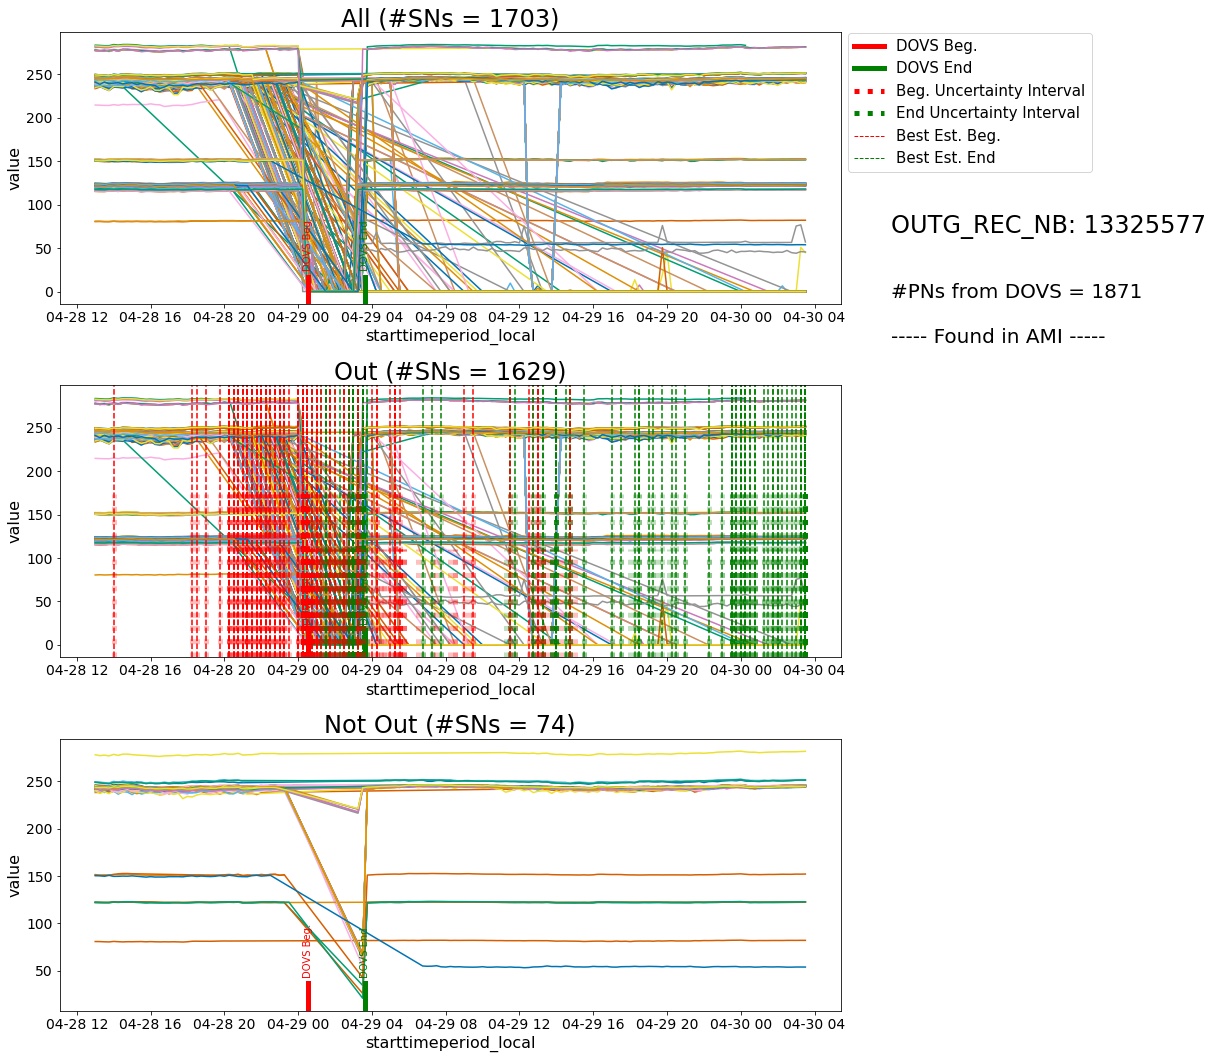

In [10]:
fig_num = 0

#-------------------------
# Build dovs_df
dovs = DOVSOutages(
    df_construct_type=DFConstructType.kRunSqlQuery, 
    contstruct_df_args=None, 
    init_df_in_constructor=True,
    build_sql_function=DOVSOutages_SQL.build_sql_outage, 
    build_sql_function_kwargs=dict(
        outg_rec_nbs=all_outg_rec_nbs, 
        field_to_split='outg_rec_nbs', 
        include_premise=True
    ), 
    build_consolidated=True
)
dovs_df = dovs.df.copy()

#-------------------------
# Now, iterate through all outages
for i_outg, outg_rec_nb in enumerate(all_outg_rec_nbs):
    print(f'\n\ti_outg: {i_outg+1}/{len(all_outg_rec_nbs)}')
    print(f'\toutg_rec_nb = {outg_rec_nb}')
    #-----
    ami_df = GenAn.read_df_from_csv_batch(outg_rec_nb_to_files_dict[outg_rec_nb])
    #--------------------------------------------------
    ami_df_i = ami_df[ami_df['OUTG_REC_NB_GPD_FOR_SQL']==outg_rec_nb].copy()
    
    # Although I cannot yet call choose_best_slicer_and_perform_slicing and reduce_INSTV_ABC_1_vals_in_df, 
    #   as the standard cleaning and conversions must be done first, I am able to cut down the size of
    #   ami_df_i by joining the slicers with 'or' statements.
    # Thus, ami_df_i will be reduced to only the subset of data which will be considered in 
    #   choose_best_slicer_and_perform_slicing
    # As mentioned, this will cut down the size of ami_df_i and will also save time and resources by not having
    #   to run entire DF through cleaning and conversions procedures.
    ami_df_i = DFSlicer.combine_slicers_and_perform_slicing(
        df=ami_df_i, 
        slicers=slicers, 
        join_slicers='or'
    )
    if ami_df.shape[0]==0:
        continue
        
    #--------------------------------------------------
    ami_df_i = AMINonVee.perform_std_initiation_and_cleaning(ami_df_i)
    #-----
    # Should the following be added to AMINonVee.perform_std_initiation_and_cleaning?
    ami_df_i = Utilities_dt.strip_tz_info_and_convert_to_dt(
        df=ami_df_i, 
        time_col='starttimeperiod', 
        placement_col='starttimeperiod_local', 
        run_quick=True, 
        n_strip=6, 
        inplace=False
    )
    ami_df_i = Utilities_dt.strip_tz_info_and_convert_to_dt(
        df=ami_df_i, 
        time_col='endtimeperiod', 
        placement_col='endtimeperiod_local', 
        run_quick=True, 
        n_strip=6, 
        inplace=False
    )
    #--------------------------------------------------
    ami_df_i = choose_best_slicer_and_perform_slicing(
        df=ami_df_i, 
        slicers=slicers, 
        groupby_SN=True, 
        t_search_min_max=None, 
        time_col='starttimeperiod_local', 
        value_col=None, 
        SN_col='serialnumber', 
        return_sorted=True
    )

    ami_df_i = reduce_INSTV_ABC_1_vals_in_df(
        df=ami_df_i, 
        value_col='value', 
        aep_derived_uom_col='aep_derived_uom', 
        aep_srvc_qlty_idntfr_col='aep_srvc_qlty_idntfr', 
        output_aep_srvc_qlty_idntfr = 'INSTV(ABC)1'
    )

    if ami_df_i.shape[0]==0:
        continue
        
    #-------------------------
    # Each serial number should have a single value per time stamp
    assert(ami_df_i.groupby(['serialnumber', 'starttimeperiod_local']).ngroups == ami_df_i.shape[0])

    #-------------------------
#     to_include_i = assess_outage_inclusion_requirements(
#         ami_df_i=ami_df_i, 
#         outg_rec_nb=outg_rec_nb, 
#         dovs_df=dovs_df, 
#         max_pct_PNs_missing_allowed=0

#     )
#     if not to_include_i:
#         print(f'outg_rec_nb={outg_rec_nb} did not pass inclusion requirements, skipping!!!!!')
#         continue
        
    n_SNs  = ami_df_i['serialnumber'].nunique()
    n_PNs  = ami_df_i['aep_premise_nb'].nunique()
    
    #----------------------------------------------------------------------------------------------------
    # NOTE: Can save time by grabbing ede_df_i then performing tz conversion and adding DOVS
    if outg_rec_nb not in outg_rec_nb_to_files_ede_dict.keys():
        ede_df_i=None
    else:
        ede_df = GenAn.read_df_from_csv_batch(outg_rec_nb_to_files_ede_dict[outg_rec_nb])
        ede_df_i = ede_df[ede_df['OUTG_REC_NB_GPD_FOR_SQL']==outg_rec_nb].copy()

        #-----
        ede_df_i = Utilities_dt.strip_tz_info_and_convert_to_dt(
            df=ede_df_i, 
            time_col='valuesinterval', 
            placement_col='valuesinterval_local', 
            run_quick=True, 
            n_strip=6, 
            inplace=False
        )
        ede_df_i = AMIEndEvents.reduce_end_event_reasons_in_df(df=ede_df_i)
        #-----
        ede_cols_to_keep = [
            'valuesinterval_local', 
            'reason', 
            'serialnumber', 
            'aep_premise_nb', 
            'enddeviceeventtypeid', 
            'event_type', 
            'OUTG_REC_NB_GPD_FOR_SQL', 
            'trsf_pole_nb_GPD_FOR_SQL',
        ]
        ede_df_i = ede_df_i[ede_cols_to_keep]
    #----------------------------------------------------------------------------------------------------
    dovs_df_i = DOVSOutages.retrieve_outage_from_dovs_df(
        dovs_df=dovs_df, 
        outg_rec_nb=outg_rec_nb, 
        outg_rec_nb_idfr='index', 
        assert_outg_rec_nb_found=True
    )
    assert(dovs_df_i.shape[0]==1)
    # Get the outage time from DOVS
    dovs_outg_t_beg_end = dovs_df_i.iloc[0][['DT_OFF_TS_FULL', 'DT_ON_TS']].tolist()
    assert(len(dovs_outg_t_beg_end)==2)
    dovs_outg_t_beg, dovs_outg_t_end = dovs_outg_t_beg_end
    #-------------------------
    # Get the CI and CMI from DOVS
    ci_cmi_dovs = dovs_df_i.iloc[0][['CI_NB', 'CMI_NB']].tolist()
    assert(len(ci_cmi_dovs)==2)
    ci_dovs, cmi_dovs = ci_cmi_dovs
    #-------------------------
    # Get the number of premises from DOVS
    n_PNs_dovs = len(dovs_df_i.iloc[0]['premise_nbs'])
    #--------------------------------------------------
    res_dict = calculate_ci_cmi_w_ami_w_ede_help(
        df=ami_df_i, 
        ede_df=ede_df_i, 
        dovs_outg_t_beg_end=dovs_outg_t_beg_end, 
        expand_outg_search_time=pd.Timedelta('1 hour'), 
        conservative_estimate=True, 
        est_ede_kwargs=None, 
        audit_selection_method='ede only', 
        return_CI_SNs=False, 
        use_est_outg_times=True, 
        pct_SNs_required_for_outage_est=0, 
    #     expand_outg_est_search_time=pd.Timedelta('1 hour'), 
        expand_outg_est_search_time=pd.Timedelta('12 hours'), 
        use_only_overall_endpoints_of_est_outg_times=False, 
        time_col='starttimeperiod_local', 
        value_col='value', 
        SN_col='serialnumber', 
        return_all_best_ests=True, 
        return_all_best_ests_type='pd.DataFrame'
    )
    #-----
    ci_NEWEST    = res_dict['CI']
    cmi_NEWEST   = res_dict['CMI']
    best_ests_df = res_dict['all_best_ests']
    #--------------------------------------------------
    if calculate_by_PN and best_ests_df.shape[0]>0:
        best_ests_df = combine_PNs_in_best_ests_df(
            best_ests_df, 
            likeness_thresh = pd.Timedelta('1 minutes'), 
            SN_col = 'SN', 
            PN_col = 'PN', 
            i_outg_col = 'i_outg'     
        )
        ci_NEWEST  = best_ests_df['PN'].nunique()
        cmi_NEWEST = (best_ests_df['winner_max']-best_ests_df['winner_min']).sum().total_seconds()/60
    #--------------------------------------------------
    eps_min=5
    min_samples=2
    ests_to_include_in_clustering = ['winner_min', 'winner_max']
    ests_to_include_in_output = ['winner_min', 'winner_max', 'conservative_min', 'conservative_max', 'zero_times_min', 'zero_times_max']
    #-----
    if best_ests_df.shape[0]>0:
        means_df, best_ests_df_w_db_lbl = get_mean_times_w_dbscan(
            best_ests_df, 
            eps_min=eps_min, 
            min_samples=min_samples, 
            ests_to_include_in_clustering=ests_to_include_in_clustering,
            ests_to_include_in_output=ests_to_include_in_output, 
            return_labelled_best_ests_df=True
        )
    else:
        means_df, best_ests_df_w_db_lbl = None, None
    #----------------------------------------------------------------------------------------------------
    if means_df is not None:
        cnsrvtv_out_t_beg = np.min([means_df.min().min(), dovs_outg_t_beg])
        cnsrvtv_out_t_end = np.max([means_df.max().max(), dovs_outg_t_end])
    else:
        cnsrvtv_out_t_beg = dovs_outg_t_beg
        cnsrvtv_out_t_end = dovs_outg_t_end
    #--------------------------------------------------
    # Instead of using get_full_part_not_outage_subset_dfs, simply grab the PNs which suffered
    #   outages from best_ests_df
    if best_ests_df.shape[0]>0:
        outg_SNs = best_ests_df['PN'].unique().tolist()
    else:
        outg_SNs = []
    #-----
    ami_df_i_out      = ami_df_i[ami_df_i['aep_premise_nb'].isin(outg_SNs)]
    ami_df_i_not_out  = ami_df_i[~ami_df_i['aep_premise_nb'].isin(outg_SNs)]  
    #----------------------------------------------------------------------------------------------------
    fig, axs = Plot_General.default_subplots(
        n_x=1,
        n_y=3,
        fig_num=fig_num,
        sharex=False,
        sharey=False,
        unit_figsize_width=14,
        unit_figsize_height=6, 
        return_flattened_axes=True,
        row_major=True
    )
    Plot_General.adjust_subplots_args(fig, dict(hspace=0.30))

    palette = Plot_General.get_standard_colors_dict(
        keys=ami_df_i['serialnumber'].unique().tolist(), 
        palette='colorblind'
    )

    #-------------------------
    i_subplot=0
    fig, axs[i_subplot] = AMINonVee.plot_usage_around_outage(
        fig=fig, 
        ax=axs[i_subplot], 
        data=ami_df_i, 
        x='starttimeperiod_local', 
        y='value', 
        hue='serialnumber', 
        out_t_beg=dovs_outg_t_beg, 
        out_t_end=dovs_outg_t_end, 
        expand_time=pd.Timedelta('1 hour'), 
        plot_time_beg_end=[cnsrvtv_out_t_beg, cnsrvtv_out_t_end], 
        data_label='', 
        title_args=dict(label=f"All (#SNs = {ami_df_i['serialnumber'].nunique()})", fontdict=dict(fontsize=24)), 
        ax_args=None, 
        xlabel_args=None, 
        ylabel_args=None, 
        df_mean=None, 
        df_mean_col=None, 
        mean_args=None, 
        draw_outage_limits=True, 
        draw_outage_limits_kwargs=dict(alpha=1.0, linewidth=5.0, ymax=0.1), 
        include_outage_limits_text=dict(
            out_t_beg_text='DOVS Beg.', 
            out_t_beg_ypos=(0.12, 'ax_coord'), 
            out_t_beg_va='bottom', 
            out_t_beg_ha='center', 
            out_t_beg_color='red', 
            #-----
            out_t_end_text='DOVS End', 
            out_t_end_ypos=(0.12, 'ax_coord'), 
            out_t_end_va='bottom', 
            out_t_end_ha='center', 
            out_t_end_color='green', 
        ), 
        draw_without_hue_also=False, 
        seg_line_freq=None, 
        palette=palette
    )
    axs[i_subplot].legend().set_visible(False)

    Plot_General.set_general_plotting_args(
        ax=axs[i_subplot], 
        tick_args =[
            dict(axis='x', labelrotation=0, labelsize=14.0, direction='out'), 
            dict(axis='y', labelrotation=0, labelsize=14.0, direction='out')
        ], 
        xlabel_args=dict(xlabel=axs[i_subplot].get_xlabel(), fontsize=16), 
        ylabel_args=dict(ylabel=axs[i_subplot].get_ylabel(), fontsize=16)
    )


    #-------------------------
    i_subplot=1
    if ami_df_i_out.shape[0]>0:
        fig, axs[i_subplot] = AMINonVee.plot_usage_around_outage(
            fig=fig, 
            ax=axs[i_subplot], 
            data=ami_df_i_out, 
            x='starttimeperiod_local', 
            y='value', 
            hue='serialnumber', 
            out_t_beg=dovs_outg_t_beg, 
            out_t_end=dovs_outg_t_end, 
            expand_time=pd.Timedelta('1 hour'), 
            plot_time_beg_end=[cnsrvtv_out_t_beg, cnsrvtv_out_t_end], 
            data_label='', 
            title_args=dict(label=f"Out (#SNs = {ami_df_i_out['serialnumber'].nunique()})", fontdict=dict(fontsize=24)), 
            ax_args=None, 
            xlabel_args=None, 
            ylabel_args=None, 
            df_mean=None, 
            df_mean_col=None, 
            mean_args=None, 
            draw_outage_limits=True, 
            draw_outage_limits_kwargs=dict(alpha=1.0, linewidth=5.0, ymax=0.1), 
            include_outage_limits_text=dict(
                out_t_beg_text='DOVS Beg.', 
                out_t_beg_ypos=(0.12, 'ax_coord'), 
                out_t_beg_va='bottom', 
                out_t_beg_ha='center', 
                out_t_beg_color='red', 
                #-----
                out_t_end_text='DOVS End', 
                out_t_end_ypos=(0.12, 'ax_coord'), 
                out_t_end_va='bottom', 
                out_t_end_ha='center', 
                out_t_end_color='green', 
            ), 
            draw_without_hue_also=False, 
            seg_line_freq=None, 
            palette=palette
        )
        axs[i_subplot].legend().set_visible(False)
        add_all_best_ests_to_axis(
            axs[i_subplot], 
            means_df, 
            line_kwargs_by_est_key=dict(
                conservative=dict(alpha=0.25, linewidth=5.0, ymax=0.6), 
                zero_times=dict(alpha=0.25, linewidth=5.0, ymax=0.4) 
            ), 
            keys_to_include=['winner', 'conservative', 'zero_times']
        )
        Plot_General.set_general_plotting_args(
            ax=axs[i_subplot], 
            tick_args =[
                dict(axis='x', labelrotation=0, labelsize=14.0, direction='out'), 
                dict(axis='y', labelrotation=0, labelsize=14.0, direction='out')
            ], 
            xlabel_args=dict(xlabel=axs[i_subplot].get_xlabel(), fontsize=16), 
            ylabel_args=dict(ylabel=axs[i_subplot].get_ylabel(), fontsize=16)
        )
    else:
        axs[i_subplot].set_title(
            label=f'Out', 
            fontdict=dict(fontsize=24)
        )

    #-------------------------
    i_subplot=2
    if ami_df_i_not_out.shape[0]>0:
        fig, axs[i_subplot] = AMINonVee.plot_usage_around_outage(
            fig=fig, 
            ax=axs[i_subplot], 
            data=ami_df_i_not_out, 
            x='starttimeperiod_local', 
            y='value', 
            hue='serialnumber', 
            out_t_beg=dovs_outg_t_beg, 
            out_t_end=dovs_outg_t_end, 
            expand_time=pd.Timedelta('1 hour'), 
            plot_time_beg_end=[cnsrvtv_out_t_beg, cnsrvtv_out_t_end], 
            data_label='', 
            title_args=dict(label=f"Not Out (#SNs = {ami_df_i_not_out['serialnumber'].nunique()})", fontdict=dict(fontsize=24)), 
            ax_args=None, 
            xlabel_args=None, 
            ylabel_args=None, 
            df_mean=None, 
            df_mean_col=None, 
            mean_args=None, 
            draw_outage_limits=True, 
            draw_outage_limits_kwargs=dict(alpha=1.0, linewidth=5.0, ymax=0.1), 
            include_outage_limits_text=dict(
                out_t_beg_text='DOVS Beg.', 
                out_t_beg_ypos=(0.12, 'ax_coord'), 
                out_t_beg_va='bottom', 
                out_t_beg_ha='center', 
                out_t_beg_color='red', 
                #-----
                out_t_end_text='DOVS End', 
                out_t_end_ypos=(0.12, 'ax_coord'), 
                out_t_end_va='bottom', 
                out_t_end_ha='center', 
                out_t_end_color='green', 
            ), 
            draw_without_hue_also=False, 
            seg_line_freq=None, 
            palette=palette
        )
        axs[i_subplot].legend().set_visible(False)

        Plot_General.set_general_plotting_args(
            ax=axs[i_subplot], 
            tick_args =[
                dict(axis='x', labelrotation=0, labelsize=14.0, direction='out'), 
                dict(axis='y', labelrotation=0, labelsize=14.0, direction='out')
            ], 
            xlabel_args=dict(xlabel=axs[i_subplot].get_xlabel(), fontsize=16), 
            ylabel_args=dict(ylabel=axs[i_subplot].get_ylabel(), fontsize=16)
        )
    else:
        axs[i_subplot].set_title(label='Not Out', fontdict=dict(fontsize=24))


    #--------------------------------------------------
    # Add legend to first plot
    patch_dovs_beg = Line2D(
        [0], [0], color='red', 
        alpha=1.0, linewidth=5.0, linestyle='-', 
        label='DOVS Beg.'
    )
    patch_dovs_end = Line2D(
        [0], [0], color='green', 
        alpha=1.0, linewidth=5.0, linestyle='-', 
        label='DOVS End'
    )
    #-----
    patch_ui_beg =  Line2D(
        [0], [0], color='red', 
        alpha=1.0, linewidth=5.0, linestyle=':', 
        label='Beg. Uncertainty Interval'
    )
    patch_ui_end =  Line2D(
        [0], [0], color='green', 
        alpha=1.0, linewidth=5.0, linestyle=':', 
        label='End Uncertainty Interval'
    )
    #-----
    patch_best_beg =  Line2D(
        [0], [0], color='red', 
        alpha=1.0, linewidth=1.0, linestyle='--', 
        label='Best Est. Beg.'
    )
    patch_best_end =  Line2D(
        [0], [0], color='green', 
        alpha=1.0, linewidth=1.0, linestyle='--', 
        label='Best Est. End'
    )
    #-------------------------
    leg_1 = axs[0].legend(
        title=None, 
        handles=[patch_dovs_beg, patch_dovs_end, patch_ui_beg, patch_ui_end, patch_best_beg, patch_best_end], 
        bbox_to_anchor=(1, 1.025), 
        loc='upper left', 
        fontsize=15
    )        

    #--------------------------------------------------
    ci_info_fontsize = 20
    left_text_x=0.95
    right_text_x = 1.05

    fig.text(left_text_x, 0.725, f'OUTG_REC_NB: {outg_rec_nb}', fontsize=ci_info_fontsize+4)

    fig.text(left_text_x, 0.675, f"#PNs from DOVS = {n_PNs_dovs}", fontsize=ci_info_fontsize)

    fig.text(left_text_x, 0.640, "----- Found in AMI -----", fontsize=ci_info_fontsize)
    fig.text(left_text_x, 0.615, f"#PNs = {n_PNs_tot}", fontsize=ci_info_fontsize)
    fig.text(left_text_x, 0.590, f"#SNs = {n_SNs_tot}", fontsize=ci_info_fontsize)

    fig.text(left_text_x, 0.640, "----- Found in AMI -----", fontsize=ci_info_fontsize)
    fig.text(left_text_x, 0.615, f"#PNs = {n_PNs}", fontsize=ci_info_fontsize)
    fig.text(left_text_x, 0.590, f"#SNs = {n_SNs}", fontsize=ci_info_fontsize)

    fig.text(left_text_x, 0.485, '-----'*5+'\nDOVS\n'+'-----'*5, fontsize=ci_info_fontsize)
    fig.text(left_text_x, 0.460, f'CI    = {ci_dovs}', fontsize=ci_info_fontsize)
    fig.text(left_text_x, 0.435, f'CMI = {np.round(cmi_dovs, decimals=2)}', fontsize=ci_info_fontsize)

    fig.text(left_text_x, 0.360, '-----'*5+'\nUsing AMI\n'+'-----'*5, fontsize=ci_info_fontsize)
    fig.text(left_text_x, 0.335, f'CI    = {ci_NEWEST}', fontsize=ci_info_fontsize)
    fig.text(left_text_x, 0.310, f'CMI = {np.round(cmi_NEWEST, decimals=2)}', fontsize=ci_info_fontsize)
    #-----
    fig.text(
        left_text_x, 0.285, 
        f'$\Delta$CI    = {ci_dovs-ci_NEWEST} ({np.round(100*(ci_dovs-ci_NEWEST)/ci_dovs, decimals=2)}%)', 
        fontsize=ci_info_fontsize
    )
    fig.text(
        left_text_x, 0.260, 
        f'$\Delta$CMI = {np.round(cmi_dovs-cmi_NEWEST, decimals=2)} ({np.round(100*(cmi_dovs-cmi_NEWEST)/cmi_dovs, decimals=2)}%)', 
        fontsize=ci_info_fontsize
    )


    fig_num += 1
    pdf.savefig(fig, bbox_inches='tight')
    plt.close(fig)


In [ ]:
pdf.close()